# Stanisław Borowy - Modelling of Physical Systems lab4 assignment
## Explanation

Following is numeric solution to advection-diffusion equation using upwind-scheme and its comparison with analytical one.

As an analytical solution following equation will be used:
$$
C(x, t) = \frac{1}{\sqrt{4\pi\mu t}}e^{-\frac{(x - ut)^2}{4\mu t}},
$$
where $\mu$ is constant diffusion coefficient and $u$ is advection constant coefficient.

Advection-diffusion is a fundamental equation that can model pollutant transport in rivers or the atmosphere, heat transfer in fluids
or mixing of fluids, among others.

In [1]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot, show_anim

### Analytical solution

In [2]:
class PsiAnalytic:
    def __init__(self, *, mu, u):
        self.mu = mu
        self.u = u
    def __call__(self, *, x, t):
        return 1 / np.sqrt(4 * np.pi * self.mu * t) * np.exp(- (x - self.u * t)**2 / (4 * self.mu * t))

### Necessary structures/functions definitions

In [3]:
def F(psi_l, psi_r, C):
    return .5 * (C + abs(C)) * psi_l + \
           .5 * (C - abs(C)) * psi_r

class shift:
    def __init__(self, add, sub):
        self.add = add
        self.sub = sub

    def __radd__(self, o):
        return slice(o.start + self.add, o.stop + self.add)

    def __rsub__(self, o):
        return slice(o.start - self.sub, o.stop - self.sub)

In [4]:
psi_analytic = PsiAnalytic(mu=.01, u=0.5)
nx = 550
x, dx = np.linspace(-2, 6, nx, endpoint=True, retstep=True)
x = x[:-1] + dx/2

In [5]:
one = shift(add=1, sub=1)
hlf = shift(add=0, sub=1)

t_min = 0.3
t_max = 5.0
nt = 1800
dt = (t_max - t_min) / nt

i = slice(1, nx-2)
im = slice(1, nx-1)

### Plotting analytical solution

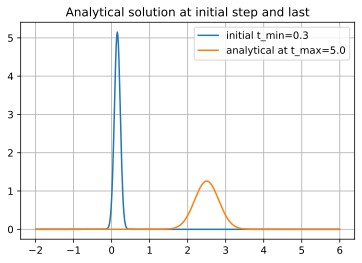

In [6]:
pyplot.plot(x, psi_analytic(x=x,t=t_min), label=f'initial {t_min=}')
pyplot.plot(x, psi_analytic(x=x,t=t_max), label=f'analytical at {t_max=}')
pyplot.title("Analytical solution at initial step and last")
pyplot.legend()
pyplot.grid()
show_plot('analytic.pdf')

### Numeric solution

In [7]:
psi = psi_analytic(x=x, t=t_min)
C_diff = np.zeros(len(psi) - 1)
C = np.zeros((len(psi) - 1))
C_adv = psi_analytic.u * (dt / dx)
eps = 1e-10

output = [psi.copy()]
for index in range(nt + 1):
    C[im - hlf] = dt / dx * (psi_analytic.u - 2.0 * psi_analytic.mu / dx * ((psi[im] - psi[im - one]) / (psi[im] + psi[im - one] + eps)))
    psi[i] = psi[i] - (F(psi[i], psi[i + one], C[i + hlf]) - F(psi[i - one], psi[i], C[i - hlf]))
    output += [psi.copy()]

### Comparison of analytical and numeric solution

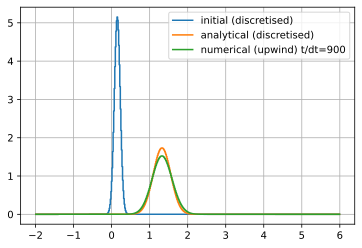

In [8]:
def plot(step):
    fig = pyplot.figure()
    pyplot.step(x, psi_analytic(x=x, t=t_min), label='initial (discretised)', where='mid')
    pyplot.step(x, psi_analytic(x=x, t=step*dt + t_min), label='analytical (discretised)', where='mid')
    pyplot.step(x, output[step], label=f'numerical (upwind) t/dt={step}', where='mid')
    pyplot.legend()
    pyplot.grid()
    return fig 
plot(nt // 2)
show_plot('numeric.pdf')

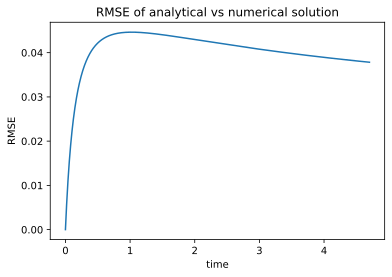

In [9]:
def rmse(y_pred, y_true):
    return np.sqrt(np.sum((y_pred - y_true) ** 2) / len(y_true))

measures = []
for step, o in enumerate(output):
    measures.append(rmse(o, psi_analytic(x=x, t=step * dt + t_min)))

times = [step * dt for step in range(len(output))]
pyplot.plot(times, measures)
pyplot.title("RMSE of analytical vs numerical solution")
pyplot.xlabel("time")
pyplot.ylabel("RMSE")
show_plot("rmse.pdf")


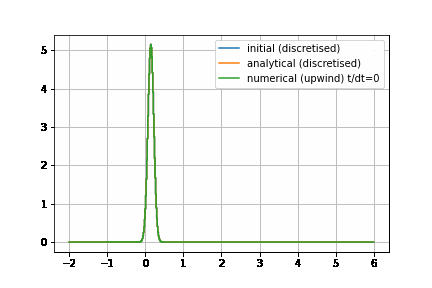

HTML(value="<a href='./tmpyd0lb93w.gif' target='_blank'>./tmpyd0lb93w.gif</a><br>")

In [10]:
show_anim(plot, range(0, nt, 3))

## Conclusions

Thanks to choosing $t_{min} > 0$, instable results for time close to 0 are omitted, and it can be generally
seen that upwind scheme provides a solution that is close to analytical one, with error being the biggest at time $t=1$,
decaying with time.